# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

from tensorflow.keras.utils import plot_model

# Utiities

In [2]:
def tensor_to_image(tensor):
  # tf.shape(tensor) returns the shape of the tensor as a TensorFlow tensor.
  # For example, if the input tensor has a shape of (1, 64, 64, 3),
  # tensor_shape will store this shape.
  tensor_shape = tf.shape(tensor)
  # tf.shape(tensor_shape) returns the shape of tensor_shape. Since tensor_shape
  # itself is a tensor, tf.shape(tensor_shape) returns its shape, which will be a
  # single number indicating the number of dimensions in tensor_shape. Typically,
  # number_elem_shape will be [4] for a 4D tensor shape.
  number_elem_shape = tf.shape(tensor_shape)
  # This line checks if the number of dimensions in tensor is greater than 3.
  # For most image data tensors used in deep learning, the shape would be either
  # 3D (height, width, channels) or 4D (batch, height, width, channels).
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    # If the tensor has more than 3 dimensions, it assumes that the first dimension
    # is the batch size and checks if it is 1 (i.e., a single image). If this is true,
    # it removes the batch dimension by setting tensor to tensor[0].
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)

def load_img(path_to_img):
  # max_dim is set to 512, which will be the maximum dimension (width or height) of
  # the image after resizing.
  max_dim = 512
  # reads the image file from the given path.
  image = tf.io.read_file(path_to_img)
  # decodes the JPEG-encoded image to a tensor.
  image = tf.image.decode_jpeg(image)
  # This line converts the image tensor to tf.float32 data type, with pixel values
  # scaled to the range [0, 1].
  image = tf.image.convert_image_dtype(image,tf.float32)

   # tf.shape(image)[:-1] gets the shape of the image excluding the last dimension
   # (which represents the color channels). This results in a tensor representing the
   # height and width of the image. tf.cast(tf.shape(image)[:-1], tf.float32) casts
   # this shape tensor to tf.float32.
  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1],tf.float32)
  # long_dim = max(shape) determines the longer dimension (either height or width) of the
  # image. scale = max_dim / long_dim calculates the scaling factor needed to resize the
  #  longer dimension to max_dim.
  long_dim = max(shape)
  scale = max_dim / long_dim

  # shape * scale scales both the height and width by the calculated factor. tf.cast(..., tf.int32)
  # casts the new shape to tf.int32.
  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image,new_shape)
  # Adding a Batch dimension
  image = image[tf.newaxis,:]
  # Convert image back to uint8
  image = tf.image.convert_image_dtype(image,tf.uint8)
  # Return image
  return image

def load_images(content_path,style_path):
  content_image = load_img("{}".format(content_path))
  style_path = load_img("{}".format(style_path))
  return content_image,style_path

def imshow(image,title = None):
  if len(image.shape) > 3:
    image = tf.squeeze(image,axis = 0)
  plt.imshow(image)
  if title:
    plt.title(title)

def show_images_with_objects(images,titles = []):
  if len(images) != len(titles):
    return

  plt.figure(figsize = (20,12))
  for idx,(image,title) in enumerate(zip(images,titles)):
    plt.subplot(1,len(images),idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image,title)

def display_gif(gif_path):
  with open(gif_path,'rb') as f:
    display_fn(Image(data = f.read(), format = 'png'))

def create_gif(gif_path,images):
  # mimsave: This is a function from the imageio library (commonly used for
  # saving and loading images and videos). It saves the images as a GIF.
  # gif_path: The path where the GIF will be saved, passed as the first argument
  # to mimsave.
  mimsave(gif_path,images,fps = 1)

  return gif_path

def clip_image_values(image,min_value = 0.0,max_value = 255.0):
  return tf.clip_by_value(image,clip_value_min = min_value,clip_value_max = max_value)

def preprocess_image(image):
  image = tf.cast(image,dtype = tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)
  return image

# Download Images

In [3]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("image files you can choose from: ")
!ls images

image files you can choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


In [4]:
# Set Default Images
content_path = f"{IMAGE_DIR}/swan.jpg"
style_path = f"{IMAGE_DIR}/painting.jpg"

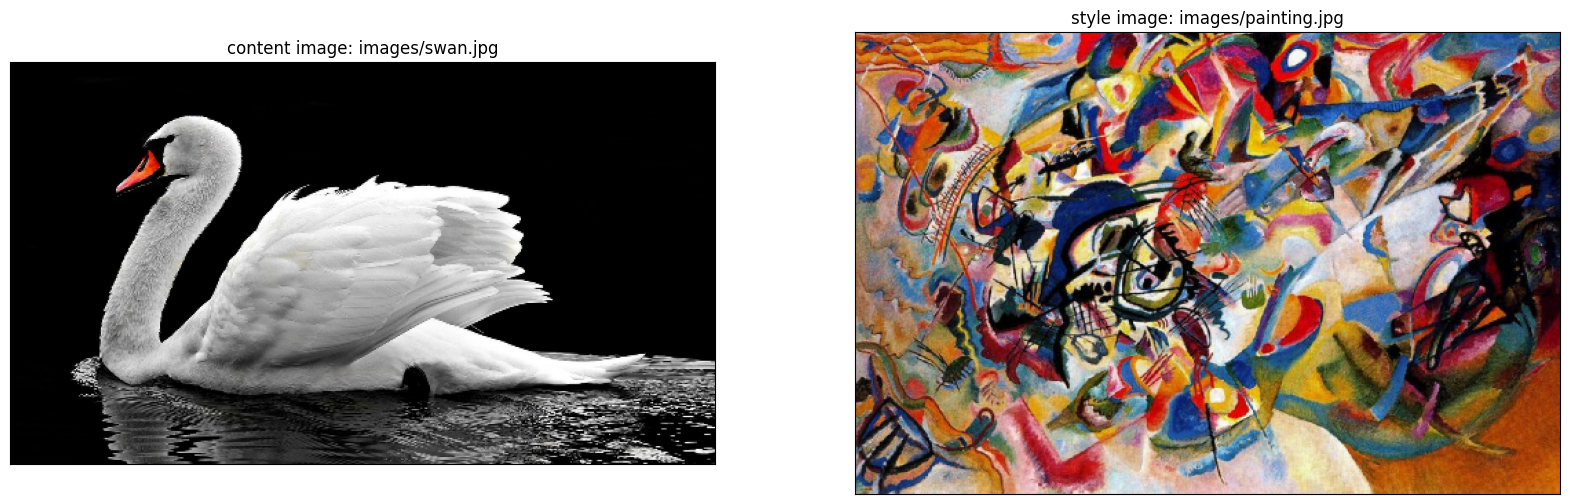

In [5]:
# Display the content and style image
content_image,style_image = load_images(content_path,style_path)
show_images_with_objects([content_image,style_image],
                         titles = [f"content image: {content_path}",
                                   f"style image: {style_path}"])

# Build the model
<img src="https://drive.google.com/uc?export=view&id=1xNii3cDPob5cX8QpXPu3S3ps8s9O5X15" width="75%" height="75%"/>

In [6]:
# Clear session to make layer naming consistent when re-running this cell
K.clear_session()

# Download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# Delete temporary variable
del tmp_vgg

574710816/574710816 [==============================] - 16s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [7]:
# Style layers of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Choose the content layer and put in a list
content_layers = ['block5_conv2']

# Combine tge two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers

# Declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [8]:
def vgg_model(layer_names):
  # Load the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(
      include_top = False,
      weights = 'imagenet'
  )

  # Freeze the weights of the model's layer
  # (make them not trainable)
  vgg.trainable = False

  # Create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # Create the model that outputs content and style layers only
  model = tf.keras.Model(inputs = vgg.input,outputs = outputs)

  return model

80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

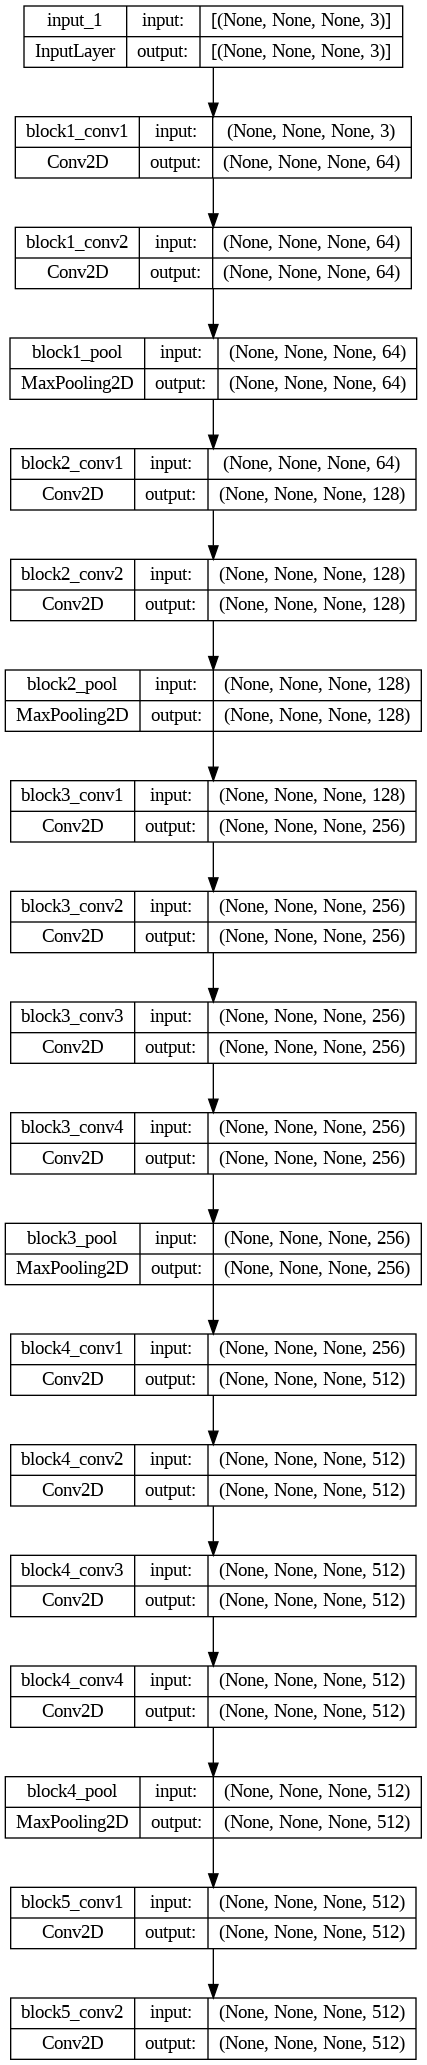

In [9]:
# Clear sessio to make layer naming consistent if re-running the cell
K.clear_session()

# Create a vgg-19 model
vgg = vgg_model(output_layers)
print(vgg.summary())
plot_file = 'vgg19_model.png'
plot_model(vgg,show_shapes = True,to_file = plot_file,show_layer_names = True)
Image(plot_file)

# Define the loss functions

### Calculate Style loss

In [10]:
def get_style_loss(features,targets):
  # Get the average of the square errors
  style_loss = tf.reduce_mean(tf.square(features - targets))

  return style_loss

### Calculate Content Loss

In [11]:
def get_content_loss(features,targets):
  # Get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))

  return content_loss

### Calculate Gram Matrix

In [12]:
# The Gram matrix is a measure of the similarity between different
# feature maps (or channels) of an image
def gram_matrix(input_tensor):
  # Calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum(
      'bijc,bijd->bcd',
      input_tensor,
      input_tensor
  )
  # Get the height and width of the input tensor
  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  # Get the number of locations (height * width)
  # and cast it as a tf.float32
  num_locations = tf.cast(height*width,tf.float32)

  # Scale the gram matrix by dividing by the number of locations

  # Normalization: By dividing by the number of locations,
  # the values in the Gram matrix are normalized. This ensures that
  # the Gram matrix values are not dependent on the size of the input tensor,
  # making comparisons between images of different sizes more meaningful.

  # Stable Training: Normalization helps to stabilize the gradients during
  # backpropagation, which can improve the convergence of the training process
  # in style transfer models.

  # Consistency: It helps in maintaining consistency in the feature map activations,
  # ensuring that the style representations are comparable across different layers and scales.
  scaled_gram = gram / num_locations

  return scaled_gram

### Get the style image features

In [13]:
tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

In [14]:
def get_style_image_features(image):
  # Preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # Get the outputs from the custom vgg model that you created using
  # vgg_model()
  outputs = vgg(preprocessed_style_image)

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store
  # these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features

### Get content image features

In [15]:
def get_content_image_features(image):
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)

  # get the outputs frm the vgg model
  outputs = vgg(preprocessed_content_image)

  # get the content layers of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  # return the content layer outputs of the content image
  return content_outputs

### Calculate the style and content loss

The total loss is given by $L_{total} = \beta L_{style} + \alpha L_{content}$, where $\beta$ and $\alpha$ are weights we will give to the content and style features to generate the new image. See how it is implemented in the function below.

In [16]:
def get_style_content_loss(style_targets,style_outputs,content_targets,
                           content_outputs,style_weight,content_weight):
  # Sum of the style losses
  style_loss = tf.add_n([get_style_loss(style_output,style_target)
                        for style_output,style_target in zip(style_outputs,style_targets)])

  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output,content_target)
                           for content_output,content_target in zip(content_outputs,content_targets)])
  # Scale the content loss by multiplying by the style weight and dividing by the nuumber of style layers
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS

  # Scale the content loss by multiplying by the style weight and dividing by the nuumber of style layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS

  # sum up the style and content losses
  total_loss = style_loss + content_loss

  return total_loss

# Generate the Stylized Image

### Calculate gradients

In [17]:
def calculate_gradients(image,style_targets,content_targets,
                        style_weight,content_weight,var_weight):
  with tf.GradientTape() as tape:
    # get the style image features
    style_features = get_style_image_features(image)

    # get the content image features
    content_features = get_content_image_features(image)

    # get the style and content loss
    loss = get_style_content_loss(style_targets,style_features,content_targets,
                                  content_features,style_weight,content_weight)

  # Calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss,image)

  return gradients

### Update the image with the style

In [18]:
def update_image_with_style(image,style_targets,content_targets,style_weight,
                            var_weight,content_weight,optimizer):
  # Calculate gradients using the function that you just defined
  gradients = calculate_gradients(image,style_targets,content_targets,
                                  style_weight,content_weight,var_weight)

  # Apply the gradients to the given image
  optimizer.apply_gradients([(gradients,image)])

  # Clip the mage using the utility clip_image_values() function
  image.assign(clip_image_values(image,min_value = 0.0,max_value = 255.0))

### Style Transfer

In [19]:
def fit_style_transfer(style_image,content_image,style_weight = 1e-2, content_weight = 1e-4,
                       var_weight = 0,optimizer = 'adam',epochs = 1,steps_per_epoch = 1):
  images = []
  step = 0

  # Get the style image features
  # extracts features from the style image
  style_targets = get_style_image_features(style_image)

  # Get the content image features
  # extracts features from the content image
  content_targets = get_content_image_features(content_image)

  # Initalize the generated image for updates
  # The content image is cast to a float32 tensor and assigned to generated_image,
  # which will be updated during training.
  generated_image = tf.cast(content_image,dtype = tf.float32)
  generated_image = tf.Variable(generated_image)

  # Collect the image updates starting from the content image
  images.append(content_image)

  # Incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1

      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image,style_targets,content_targets,
                              style_weight,var_weight,content_weight,optimizer)

      print(".", end = " ")

      if (m+1) %10 == 0:
        images.append(generated_image)

    # Display the current stylized image
    # clear_output(): This function clears the current output displayed below the code cell.
    # wait=True: This parameter, when set to True, waits to clear the output until new output
    # is available to replace it.
    # Clear the output of the cell before displaying the new generated image.
    # Ensure that the display area is updated dynamically without accumulating old images,
    # which helps in visualizing the training process.
    clear_output(wait = True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # Append to the image collection for visualization later
    images.append(generated_image)
    print("Train step : {}".format(step))

  # Convert to uint8 (expected dtype for imagees with pixels in he range [0 - 255])
  # The generated_image is cast to uint8 for visualization.
  generated_image = tf.cast(generated_image,dtype = tf.uint8)

  return generated_image,images

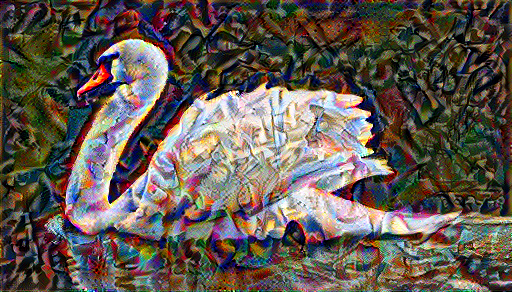

Train step : 1000


In [20]:
# Define style and content weight
style_weight = 2e-2
content_weight = 2e-2

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 20.0,decay_steps = 100,decay_rate = 0.5
    )
)

# Start the neural style transfer
stylized_image,display_images = fit_style_transfer(
    style_image = style_image,content_image = content_image,
    style_weight = style_weight, content_weight = content_weight,
    var_weight = 0,optimizer = adam,epochs = 10,steps_per_epoch = 100
)

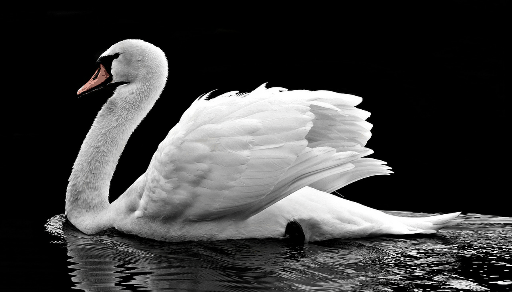

In [22]:
# Display GIF of Intermediate output

# This line defines the file path where the GIF will be saved
GIF_PATH = 'style_transfer.gif'
# image.numpy(): Converts the tensor to a NumPy array.
# np.squeeze(..., axis=0): Removes the singleton dimensions from the array,
# typically used to remove the batch dimension if the image has shape (1, height, width, channels).
# gif_images: A list containing the processed image array. This list is used to store frames for the GIF.
gif_images = [np.squeeze(image.numpy().astype(np.uint8),axis = 0) for image in display_images]
gif_path = create_gif(GIF_PATH,gif_images)
display_gif(gif_path)

# Total Variation Loss

In [23]:
# Plot Utilities
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1,:,:] - image[:,:-1,:,:]

  return x_var,y_var

def plot_deltas_for_single_image(x_deltas,y_deltas,name = 'Original', row = 1):
  plt.figure(figsize = (14,10))
  plt.subplot(row,2,1)
  plt.yticks([])
  plt.xticks([])

  clipped_y_deltas = clip_image_values(2*y_deltas + 0.5,min_value = 0.0,max_value = 1.0)
  imshow(clipped_y_deltas, "Horizontal Deltas: {}".format(name))

  plt.subplot(row,2,2)
  plt.xticks([])
  plt.yticks([])

  clipped_x_deltas = clip_image_values(2*x_deltas + 0.5,min_value = 0.0,max_value = 1.0)
  imshow(clipped_x_deltas,"Vertical Deltas {}".format(name))

def plot_deltas(original_image_deltas,stylized_image_deltas):
  orig_x_deltas,orig_y_deltas = original_image_deltas

  stylized_x_deltas,stylized_y_deltas = stylized_image_deltas

  plot_deltas_for_single_image(orig_x_deltas,orig_y_deltas,name = "Original")
  plot_deltas_for_single_image(stylized_x_deltas,stylized_y_deltas,name = "Stylized Image",row = 2)

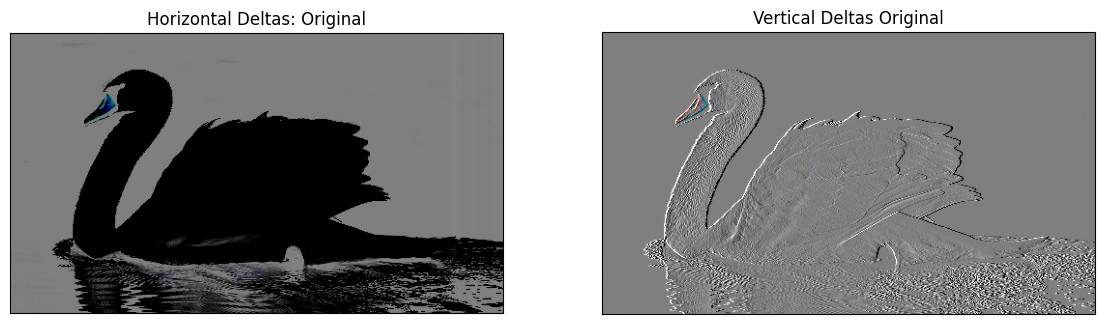

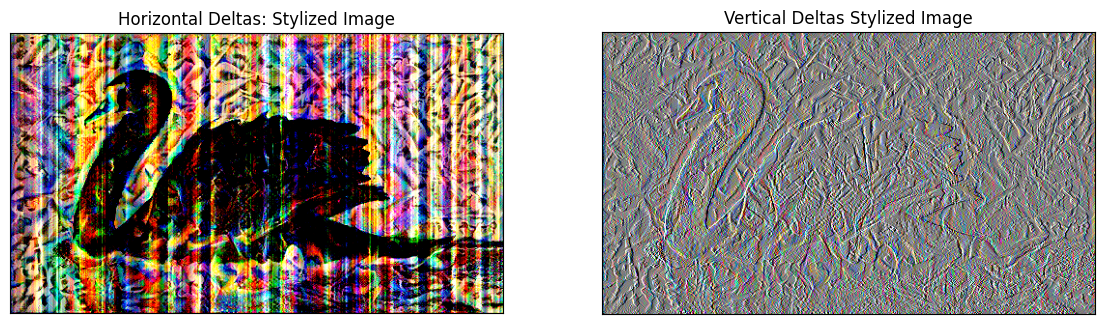

In [25]:
# Diaplay the frequency variations
original_x_deltas,original_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(content_image,dtype = tf.float32)
)

stylized_image_reg_x_deltas, stylized_image_reg_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(stylized_image,dtype = tf.float32)
)

plot_deltas((original_x_deltas,original_y_deltas),(stylized_image_reg_x_deltas,stylized_image_reg_y_deltas))

In [26]:
def calculate_gradients(image,style_targets,content_targets,
                        style_weight,content_weight,var_weight):
  with tf.GradientTape() as tape:

    # Get the style image features
    style_features = get_style_image_features(image)

    # Get the content image features
    content_features = get_content_image_features(image)

    # Get the style and content loss
    loss = get_style_content_loss(style_targets,style_features,content_targets,
                                  content_features,style_weight,content_weight)

    # Add the total variable loss
    loss += var_weight * tf.image.total_variation(image)

  # Calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss,image)

  return gradients